# CDK2 Interpolation in Latent Space

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
import rdkit.Chem.PandasTools as PandasTools

PandasTools.InstallPandasTools()

In [4]:
import os

### Analysis Variables

In [5]:
blob = "lig_gen"

### Helper Functions

TODO: Extract such functions in a Python module.

In [6]:
def root_and_prefix(datafile):
    """
    Root directory and prefix.
    """
    dataroot = os.path.dirname(datafile)
    prefix, _ = os.path.splitext(os.path.basename(datafile))

    return dataroot, prefix

## Variability Factor 1.0

### Data

In [15]:
droot = "data/CDK2/data"

In [16]:
datafile = "generated/CDK2recinterpolation_vf1.0_inter.gen_metrics"

Load generative model metrics (from `*.gen_metrics` file):

In [17]:
dataroot, prefix = root_and_prefix(datafile)
prefix

'CDK2recinterpolation_vf1.0_inter'

In [18]:
system = prefix.split("_")[0]
system

'CDK2recinterpolation'

In [19]:
with open(f"data/{system}.types", "r") as f:
    inputs = f.readlines()

inputs

['1 0.00 CDK2/data/4EK4.pdb CDK2/data/4ek4_B_1CK.sdf\n',
 '1 0.00 CDK2/data/4FKJ.pdb CDK2/data/4fkj_B_11K.sdf\n',
 '1 0.00 CDK2/data/4FKP.pdb CDK2/data/4fkp_B_LS5.sdf\n',
 '1 0.00 CDK2/data/4FKW.pdb CDK2/data/4fkw_B_62K.sdf\n']

In [20]:
def ligname(line):
    ligfile = line.strip().split()[-1]
    ligname = os.path.splitext(os.path.basename(ligfile))[0]
    return ligname


ligand_pairs = [
    (ligname(inputs[i]), ligname(inputs[i + 1])) for i in range(0, len(inputs), 2)
]
ligand_pairs

[('4ek4_B_1CK', '4fkj_B_11K'), ('4fkp_B_LS5', '4fkw_B_62K')]

In [21]:
interpolations = {}

In [22]:
for ligandpair in ligand_pairs:
    molecules = []

    lig1, lig2 = ligandpair

    # Start molecule
    molecules.append(next(Chem.SDMolSupplier(f"{droot}/{lig1}.sdf")))
    AllChem.Compute2DCoords(molecules[0])

    lig1f = f"generated/{prefix}_{lig1}_{blob}_fit_add.sdf"
    suppl1 = Chem.SDMolSupplier(lig1f)
    for mol in suppl1:
        if mol is not None:
            AllChem.Compute2DCoords(mol)
            molecules.append(mol)

    lig2f = f"generated/{prefix}_{lig2}_{blob}_fit_add.sdf"
    suppl2 = Chem.SDMolSupplier(lig2f)
    for mol in suppl2:
        if mol is not None:
            AllChem.Compute2DCoords(mol)
            molecules.append(mol)

    # End molecule
    molecules.append(next(Chem.SDMolSupplier(f"{droot}/{lig2}.sdf")))
    AllChem.Compute2DCoords(molecules[-1])

    interpolations[f"{lig1}/{lig2}"] = molecules

In [23]:
def tsimilarity(molecules):

    fps = [
        AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in molecules
    ]

    start_fp = fps[0]
    end_fp = fps[-1]

    sim_with_start = []
    sim_with_end = []
    for fp in fps:
        sim_with_start.append(DataStructs.FingerprintSimilarity(fp, start_fp))
        sim_with_end.append(DataStructs.FingerprintSimilarity(fp, end_fp))

    return sim_with_start[1:-1], sim_with_end[1:-1]

In [24]:
def msimilarity(molecules):
    from rdkit.Chem import MACCSkeys

    fps = [MACCSkeys.GenMACCSKeys(mol) for mol in molecules]

    start_fp = fps[0]
    end_fp = fps[-1]

    sim_with_start = []
    sim_with_end = []
    for fp in fps:
        sim_with_start.append(DataStructs.FingerprintSimilarity(fp, start_fp))
        sim_with_end.append(DataStructs.FingerprintSimilarity(fp, end_fp))

    return sim_with_start[1:-1], sim_with_end[1:-1]

## First Interpolation

In [25]:
idx = 0  # Interpolation index (first pair, second pair, ...)
key = list(interpolations.keys())[idx]

In [26]:
key

'4ek4_B_1CK/4fkj_B_11K'

In [27]:
tsim_start, tsim_end = tsimilarity(interpolations[key])

Text(0, 0.5, 'Tanimoto Similatiry')

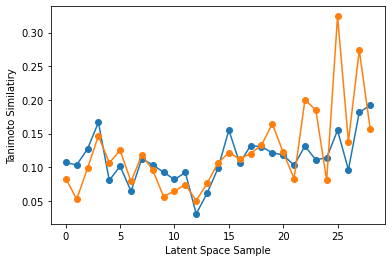

In [28]:
plt.plot(range(len(tsim_start)), tsim_start, "o-", label="Similatiry to START")
plt.plot(range(len(tsim_end)), tsim_end, "o-", label="Similarity to END")
plt.xlabel("Latent Space Sample")
plt.ylabel("Tanimoto Similatiry")

In [29]:
msim_start, msim_end = msimilarity(interpolations[key])

Text(0.5, 1.0, 'MACCS')

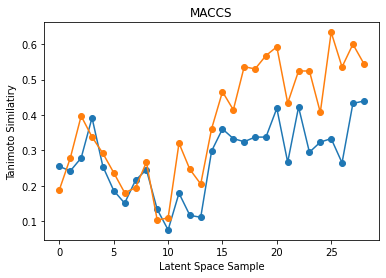

In [30]:
plt.plot(range(len(tsim_start)), msim_start, "o-", label="Similatiry to START")
plt.plot(range(len(tsim_end)), msim_end, "o-", label="Similarity to END")
plt.xlabel("Latent Space Sample")
plt.ylabel("Tanimoto Similatiry")
plt.title("MACCS")

In [31]:
df = pd.DataFrame().from_dict({"sim_start": tsim_start, "sim_end": tsim_end})
df.head()

,sim_start,sim_end
0,0.107143,0.083333
1,0.103448,0.052632
2,0.127273,0.098592
3,0.166667,0.146667
4,0.080645,0.106667


In [32]:
df.index = interpolations[key][1:-1]
df.columns = [interpolations[key][0], interpolations[key][-1]]

,,
,0.107143,0.083333
,0.103448,0.052632
,0.127273,0.098592
,0.166667,0.146667
,0.080645,0.106667
,0.101695,0.125000
,0.064516,0.078947
,0.112903,0.118421
,0.103448,0.095890
,0.092593,0.056338

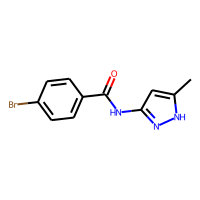
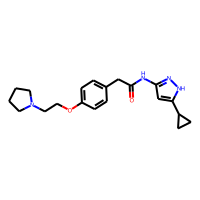
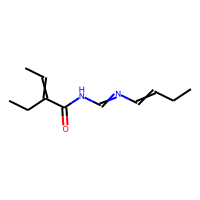
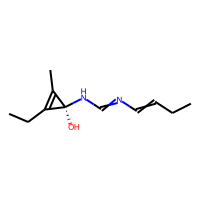
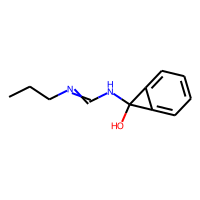
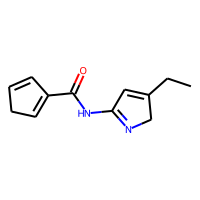
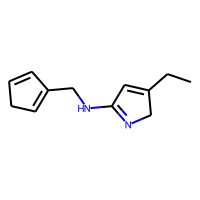
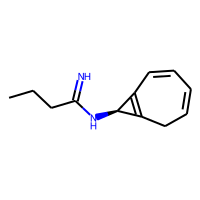
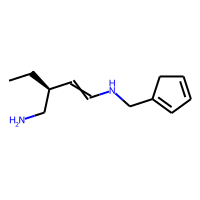
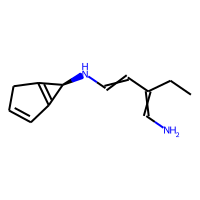
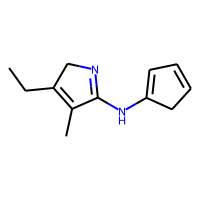
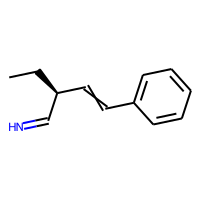
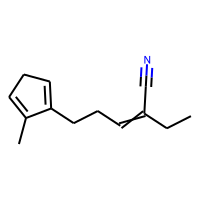
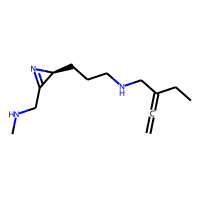
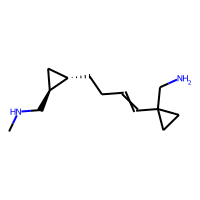
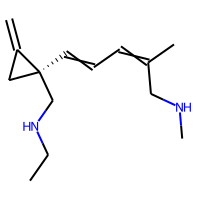
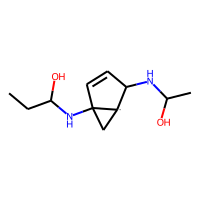
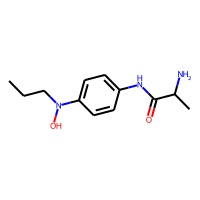
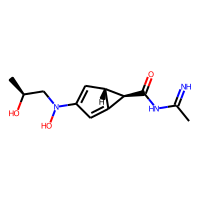
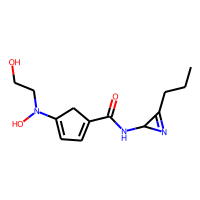
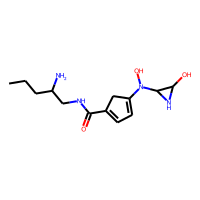
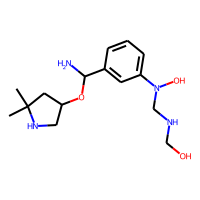
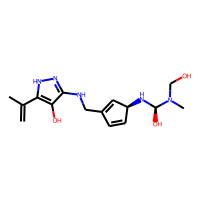
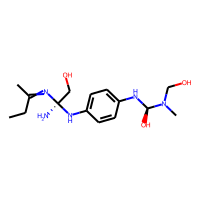
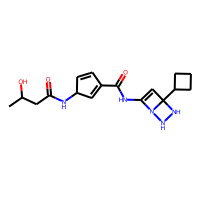
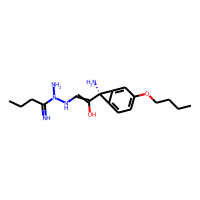
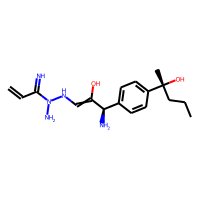
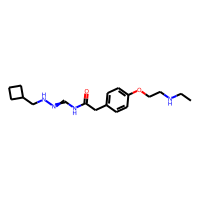
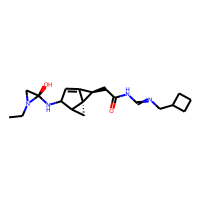
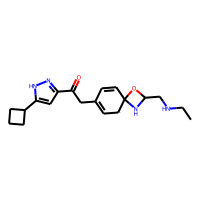
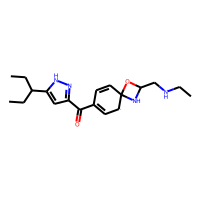

In [33]:
df.style.background_gradient(cmap=sns.cm.rocket, vmin=0, vmax=1)

<AxesSubplot:>

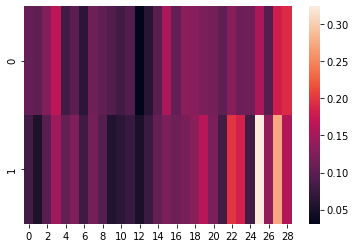

In [34]:
sns.heatmap(df.to_numpy().T)

## Second Interpolation

In [35]:
idx = 1  # Interpolation index (first pair, second pair, ...)
key = list(interpolations.keys())[idx]

In [36]:
key

'4fkp_B_LS5/4fkw_B_62K'

In [37]:
tsim_start, tsim_end = tsimilarity(interpolations[key])

Text(0, 0.5, 'Tanimoto Similatiry')

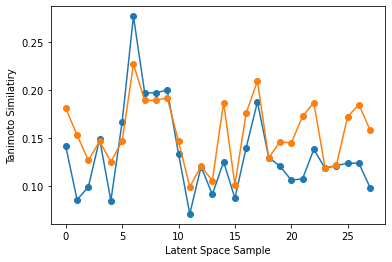

In [38]:
plt.plot(range(len(tsim_start)), tsim_start, "o-", label="Similatiry to START")
plt.plot(range(len(tsim_end)), tsim_end, "o-", label="Similarity to END")
plt.xlabel("Latent Space Sample")
plt.ylabel("Tanimoto Similatiry")

In [39]:
msim_start, msim_end = msimilarity(interpolations[key])

Text(0.5, 1.0, 'MACCS')

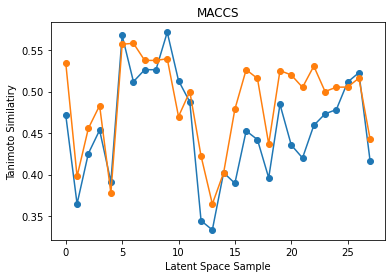

In [40]:
plt.plot(range(len(tsim_start)), msim_start, "o-", label="Similatiry to START")
plt.plot(range(len(tsim_end)), msim_end, "o-", label="Similarity to END")
plt.xlabel("Latent Space Sample")
plt.ylabel("Tanimoto Similatiry")
plt.title("MACCS")

In [41]:
df = pd.DataFrame().from_dict({"sim_start": tsim_start, "sim_end": tsim_end})
df.head()

,sim_start,sim_end
0,0.141026,0.180723
1,0.085366,0.152941
2,0.098765,0.126437
3,0.148649,0.146341
4,0.084337,0.125000


In [42]:
df.index = interpolations[key][1:-1]
df.columns = [interpolations[key][0], interpolations[key][-1]]

,,
,0.141026,0.180723
,0.085366,0.152941
,0.098765,0.126437
,0.148649,0.146341
,0.084337,0.125000
,0.166667,0.146667
,0.276923,0.226667
,0.196970,0.189189
,0.196970,0.189189
,0.200000,0.191781

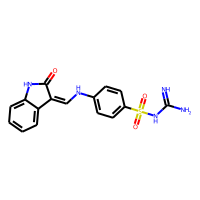
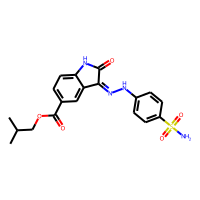
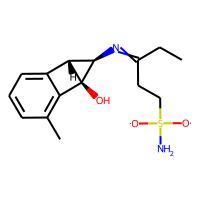
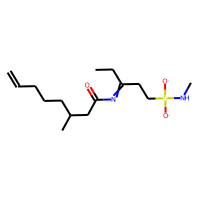
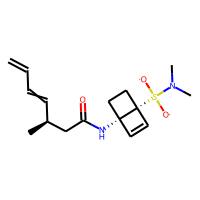
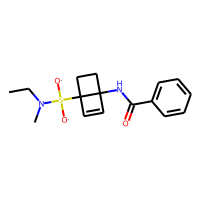
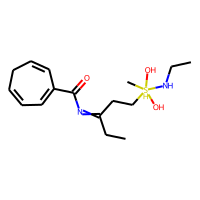
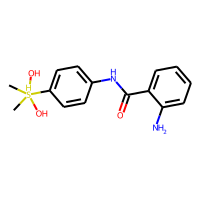
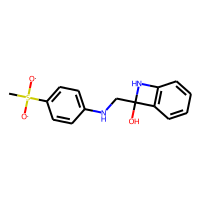
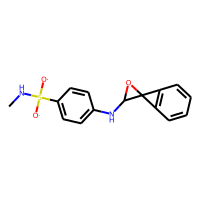
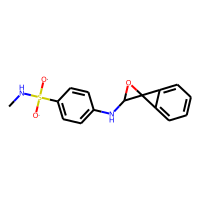
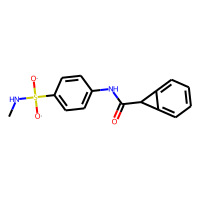
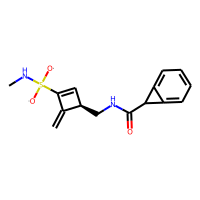
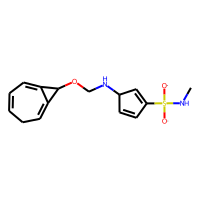
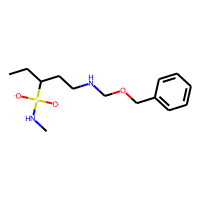
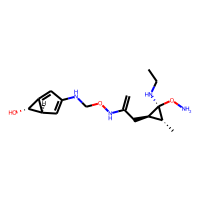
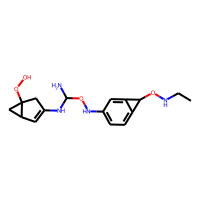
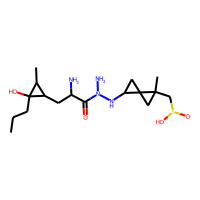
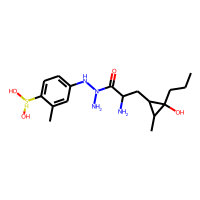
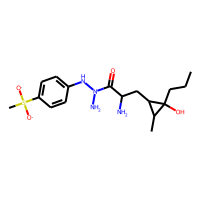
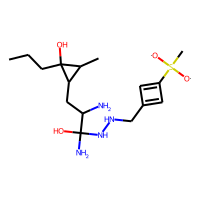
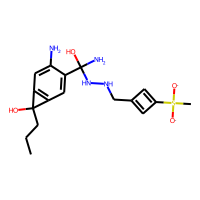
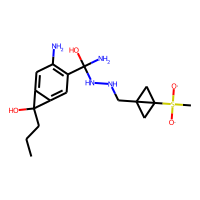
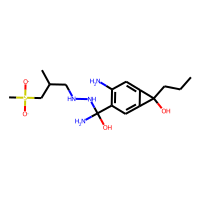
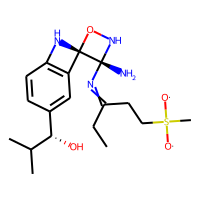
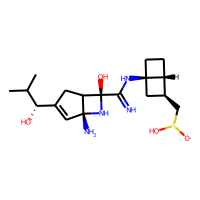
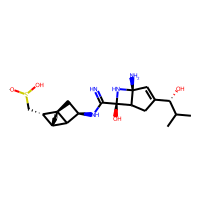
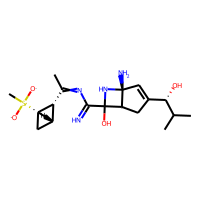
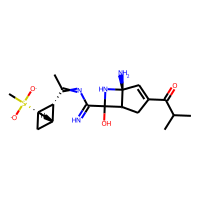
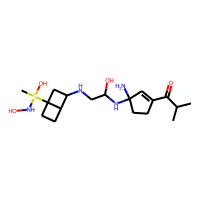

In [43]:
df.style.background_gradient(cmap=sns.cm.rocket, vmin=0, vmax=1)

<AxesSubplot:>

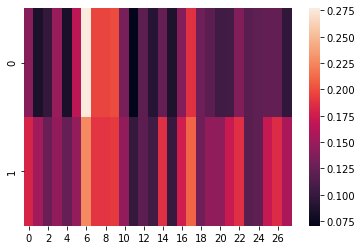

In [44]:
sns.heatmap(df.to_numpy().T)